In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from IPython import display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.linear_model import BayesianRidge, LinearRegression, Lasso, LassoCV, Lars, LassoLars
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, VotingClassifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, Trials
from sklearn.inspection import permutation_importance

In [2]:
#reading in data
df = pd.read_csv(r'Users\colem\OneDrive\Documents\Springboard\COVID-19-master\covid_data_postprocessing_weekly.csv')

In [3]:
#double check on df
df.head()

,T_avg,Prcp,New_Confirmed,New_Deaths,New_Deaths_Lag_1_week,New_Deaths_Lag_2_week,New_Deaths_Lag_3_week,New_Confirmed_Lag_1_week,New_Confirmed_Lag_2_week,New_Confirmed_Lag_3_week,New_Cases_as_percent_of_pop
0,58.717143,0.063555,412.857143,17.142857,125.0,102.0,151.0,3652.0,4734.0,4930.0,39.319728
1,64.348571,0.002812,521.714286,17.857143,102.0,151.0,99.0,4734.0,4930.0,6924.0,49.687075
2,67.460000,0.574803,676.285714,14.571429,151.0,99.0,99.0,4930.0,6924.0,8127.0,64.408163
3,72.885714,0.302025,704.285714,21.571429,99.0,99.0,88.0,6924.0,8127.0,8545.0,67.074830
4,76.562857,0.045557,989.142857,14.142857,99.0,88.0,138.0,8127.0,8545.0,9422.0,94.204082


Train Test Split

In [4]:
#before training any models on the data, we are seperating training and testing data
#creating features
X = df.drop(['New_Cases_as_percent_of_pop','New_Confirmed'], axis=1)
y = df['New_Cases_as_percent_of_pop']

In [5]:
#making test and training split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state = 123)

Linear Regression Model

In [6]:
#building and fitting linear regression model
lin_reg = LinearRegression(fit_intercept = True)
lin_reg.fit(X_train, y_train)

LinearRegression()

In [7]:
#testing linear regression model for r-squared score on training data
score = lin_reg.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [8]:
#testing linear regression model for mean squared error
ypred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20605.23


In [9]:
#testing linear regression model for the coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.85


In [10]:
#testing linear regression model for root-mean-square deviation
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 143.55


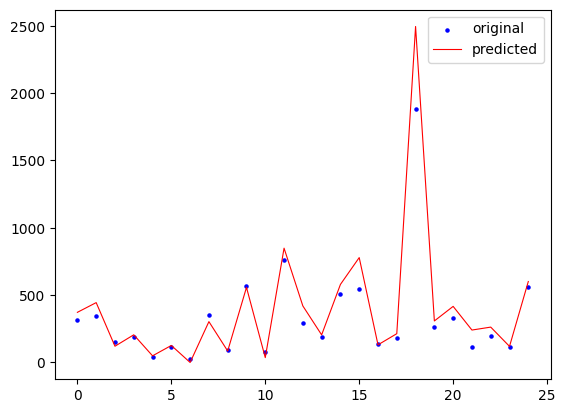

In [11]:
#plotting linear regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

very odd that linear regression model is showing as anything but a straight line

In [12]:
#using grid search to tune hyperparameters
def grid_search(model, grid):
    model_cv = GridSearchCV(estimator = model, param_grid = grid, cv = 5)
    model_cv.fit(X_train, y_train)
    return (model_cv.best_params_)

In [13]:
#determining best parameters for linear regression model
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

print(grid_search(model = LinearRegression(), grid = param_grid_lr))

{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [14]:
lin_reg_tuned = LinearRegression(fit_intercept = False, copy_X = True, normalize = True)
lin_reg_tuned.fit(X_train, y_train)

LinearRegression(fit_intercept=False, normalize=True)

In [15]:
#testing tuned linear regression model for r-squared score on training data
score = lin_reg_tuned.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [16]:
#testing tuned linear regression model for mean squared error
ypred = lin_reg_tuned.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20734.81


In [17]:
#testing tuned linear regression model for the coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.85


In [18]:
#testing tuned linear regression model for root-mean-square deviation
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 144.00


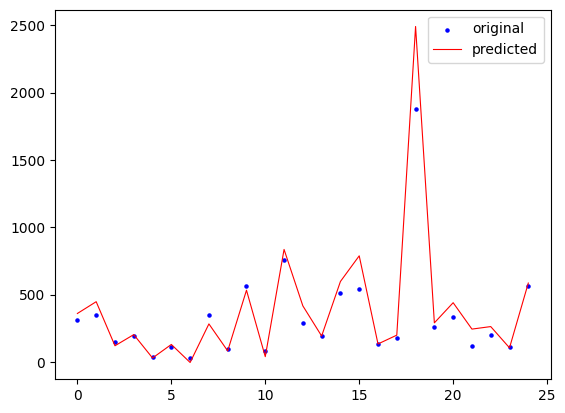

In [19]:
#plotting tuned linear regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

new tuned model is better (lower MSE, higher coefficient of determination)

Lasso Regression Model

In [20]:
#building lasso regression model with standard hyperparameters to start
las = Lasso()
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 
las.fit(X_train, y_train)

Lasso()

In [21]:
#testing lasso regression model for R-squared score on training data
score = las.score(X_train, y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [22]:
#testing lasso regression model for mean squared error
ypred = las.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20867.35


In [23]:
#testing lasso regression model for the coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.84


In [24]:
#testing lasso regression model for root-mean-squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 144.46


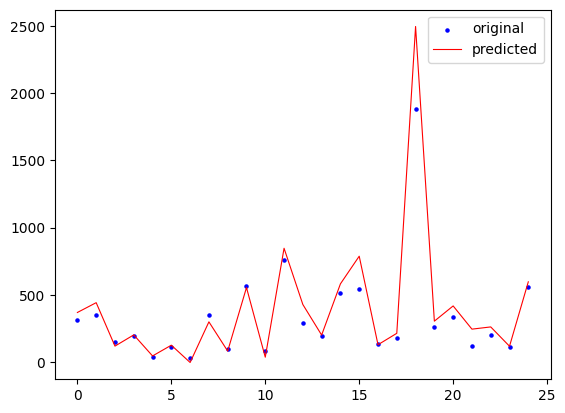

In [25]:
#plotting lasso regression model
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [26]:
#determining best parameters for lasso regression
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'positive':[True, False]}

print(grid_search(model = Lasso(), grid = param_grid_lr))

{'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': False}


Objective did not converge. You might want to increase the number of iterations. Duality gap: 4561.9574728334555, tolerance: 1713.5422790010364
Objective did not converge. You might want to increase the number of iterations. Duality gap: 426639.73877071665, tolerance: 2493.3262926189454
Objective did not converge. You might want to increase the number of iterations. Duality gap: 426639.73877071665, tolerance: 2493.3262926189454
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4561.9574728334555, tolerance: 1713.5422790010364
Objective did not converge. You might want to increase the number of iterations. Duality gap: 426639.73877071665, tolerance: 2493.3262926189454
Objective did not converge. You might want to increase the number of iterations. Duality gap: 426639.73877071665, tolerance: 2493.3262926189454


In [27]:
#building lasso regression model with standard hyperparameters to start
las_tuned = Lasso()
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 
las_tuned.fit(X_train, y_train)

Lasso()

In [28]:
#testing tuned lasso regression model for R-squared score on training data
score = las_tuned.score(X_train, y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [29]:
#testing tuned lasso regression model for mean squared error
ypred = las_tuned.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20867.35


In [30]:
#testing tuned lasso regression model for the coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.84


In [31]:
#testing tuned lasso regression model for root-mean-squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 144.46


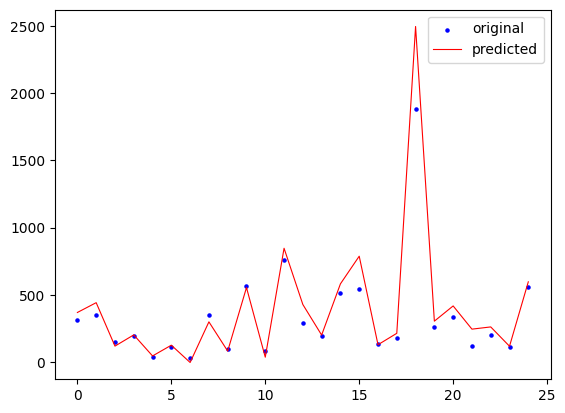

In [32]:
#plotting tuned lasso regression model
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

no difference after tuning

In [33]:
#creating pipeline to tune hyperparameter alpha for lasso regression model
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [34]:
#using 5 folds, testing for best alpha for lasso regression model
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [35]:
#fitting to training data
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] .............. model__alpha=0.1, score=-243015.250, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ............... model__alpha=0.1, score=-11840.203, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ............... model__alpha=0.1, score=-36726.379, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ............... model__alpha=0.1, score=-27469.422, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ............... model__alpha=0.1, score=-14666.859, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] .............. model__alpha=0.2, score=-237797.690, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ............... model__alpha=1.0, score=-31985.774, total=   0.0s
[CV] model__alpha=1.0 ................................................
[CV] ............... model__alpha=1.0, score=-28559.856, total=   0.0s
[CV] model__alpha=1.0 ................................................
[CV] ................ model__alpha=1.0, score=-3712.158, total=   0.0s
[CV] model__alpha=1.1 ................................................
[CV] .............. model__alpha=1.1, score=-194559.588, total=   0.0s
[CV] model__alpha=1.1 ................................................
[CV] ............... model__alpha=1.1, score=-11559.231, total=   0.0s
[CV] model__alpha=1.1 ................................................
[CV] ............... model__alpha=1.1, score=-31516.893, total=   0.0s
[CV] model__alpha=1.1 ................................................
[CV] ............... model__alpha=1.1, score=-28605.662, total=   0.0s
[CV] model__alpha=1.1 ................................................
[CV] .

[CV] . model__alpha=2.9000000000000004, score=-2762.748, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-122232.426, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-12041.180, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-29233.851, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV]  model__alpha=3.0000000000000004, score=-30130.352, total=   0.0s
[CV] model__alpha=3.0000000000000004 .................................
[CV] . model__alpha=3.0000000000000004, score=-2875.869, total=   0.0s
[CV] model__alpha=3.1 ................................................
[CV] .............. model__alpha=3.1, score=-119018.054, total=   0.0s
[CV] model__alpha=3.1 ................................................
[CV] 

[CV] ............... model__alpha=4.9, score=-31229.750, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] ............... model__alpha=4.9, score=-31988.393, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] ................ model__alpha=4.9, score=-8890.688, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] ............... model__alpha=5.0, score=-81803.083, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] ............... model__alpha=5.0, score=-12668.822, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] ............... model__alpha=5.0, score=-31337.494, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] ............... model__alpha=5.0, score=-32089.882, total=   0.0s
[CV] model__alpha=5.0 ................................................
[CV] .

[CV] ............... model__alpha=6.8, score=-62479.557, total=   0.0s
[CV] model__alpha=6.8 ................................................
[CV] ............... model__alpha=6.8, score=-13178.936, total=   0.0s
[CV] model__alpha=6.8 ................................................
[CV] ............... model__alpha=6.8, score=-31958.544, total=   0.0s
[CV] model__alpha=6.8 ................................................
[CV] ............... model__alpha=6.8, score=-33895.871, total=   0.0s
[CV] model__alpha=6.8 ................................................
[CV] ............... model__alpha=6.8, score=-10544.276, total=   0.0s
[CV] model__alpha=6.9 ................................................
[CV] ............... model__alpha=6.9, score=-61578.387, total=   0.0s
[CV] model__alpha=6.9 ................................................
[CV] ............... model__alpha=6.9, score=-13208.827, total=   0.0s
[CV] model__alpha=6.9 ................................................
[CV] .

[CV] ............... model__alpha=8.8, score=-31498.521, total=   0.0s
[CV] model__alpha=8.8 ................................................
[CV] ............... model__alpha=8.8, score=-36049.897, total=   0.0s
[CV] model__alpha=8.8 ................................................
[CV] ............... model__alpha=8.8, score=-10663.756, total=   0.0s
[CV] model__alpha=8.9 ................................................
[CV] ............... model__alpha=8.9, score=-46728.932, total=   0.0s
[CV] model__alpha=8.9 ................................................
[CV] ............... model__alpha=8.9, score=-13791.353, total=   0.0s
[CV] model__alpha=8.9 ................................................
[CV] ............... model__alpha=8.9, score=-31478.878, total=   0.0s
[CV] model__alpha=8.9 ................................................
[CV] ............... model__alpha=8.9, score=-36160.847, total=   0.0s
[CV] model__alpha=8.9 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    2.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [36]:
#checking for best alpha to use
search.best_params_

{'model__alpha': 9.9}

In [37]:
#building coefficients to check for usefulness
coefficients = search.best_estimator_.named_steps['model'].coef_

In [38]:
#displaying usefullness of coefficients
importance = np.abs(coefficients)
importance

array([ 36.06453946,   1.22431978,  15.1978094 ,   9.86345544,
        18.40295861,   0.        , 517.54653439,   6.68460747,
       141.46766451])

In [39]:
#using best alpha building tuned lasso model
las_tuned = Lasso()
Lasso(alpha=9.9, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 
las.fit(X_train, y_train)

Lasso()

In [40]:
#testing tuned lasso regression model for R-squared score on training data
score = las.score(X_train, y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [41]:
#testing tuned lasso regression model for mean squared error
ypred = las.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20867.35


In [42]:
#testing tuned lasso regression model for the coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.84


In [43]:
#testing tuned lasso regression model for root-mean-squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 144.46


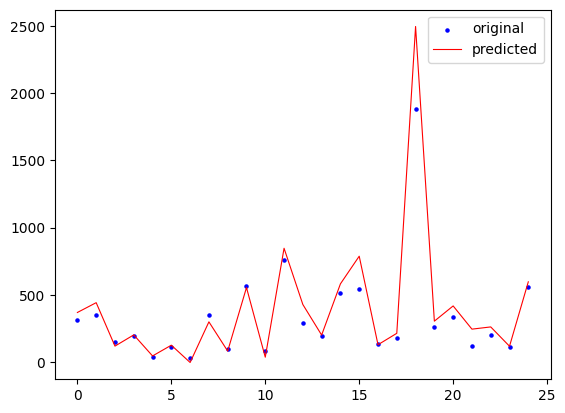

In [44]:
#plotting tuned lasso regression model 
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

no difference when changed alpha to 9.9

LassoCV Model

In [45]:
#building lassoCV model with multiple alphas
alphas = [0.1,0.3, 0.5, 0.8, 1]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X,y)
print(lassocv)

LassoCV(alphas=[0.1, 0.3, 0.5, 0.8, 1], cv=5)


In [46]:
#checking R2, MSE, RMSE at best alpha for lassoCV model
score = lassocv.score(X,y)
ypred = lassocv.predict(X_test)
mse = mean_squared_error(y_test,ypred)
print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

Alpha:1.00, R2:0.939, MSE:9807.65, RMSE:99.03


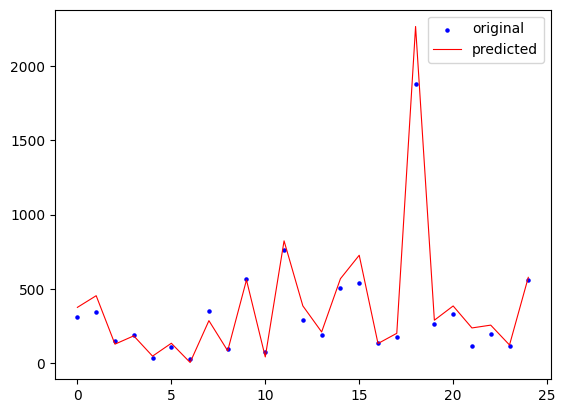

In [47]:
#plotting lassoCV model
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

Worse R2 score, better MSE and RMSE with lassoCV

Least Angles Regression Model

In [48]:
#building least angle regression model
lars = Lars()
lars.fit(X_train, y_train)

Lars()

In [49]:
#testing least angle regression model R2 score on training data
score = lars.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.75


In [50]:
#testing least angle regression model mean squared error score
ypred = lars.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 64558.82


In [51]:
#testing least angle regression model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.52


In [52]:
#testing least angle regression model root-mean-squared score 
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 254.08


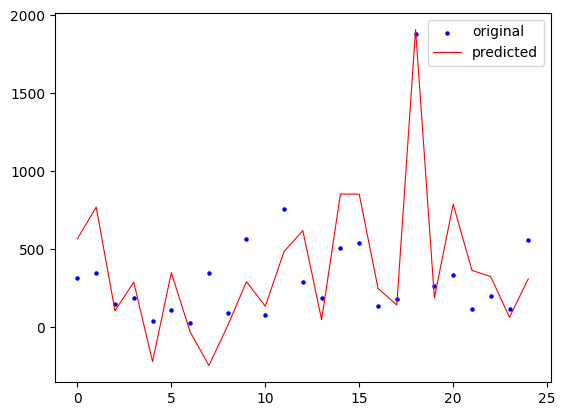

In [53]:
#plotting least angle regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

really bad results for least angle regression model, will most likely throw this out but tuning first just to make sure.

In [54]:
#determining best parameters for least angle regression
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

print(grid_search(model = Lars(), grid = param_grid_lr))

{'copy_X': True, 'fit_intercept': True, 'normalize': False}


In [55]:
#building tuned least angle regression model (all best parameters are standard other than normalize)
lars_tuned = Lars(normalize = False)
lars_tuned.fit(X_train, y_train)

Lars(normalize=False)

In [56]:
#testing tuned least angle regression model R2 score on training data
score = lars_tuned.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [57]:
#testing tuned least angle regression model mean squared error score
ypred = lars_tuned.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 20504.16


In [58]:
#testing tuned least angle regression model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.85


In [59]:
#testing tuned least angle regression model root-mean-squared score 
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 143.19


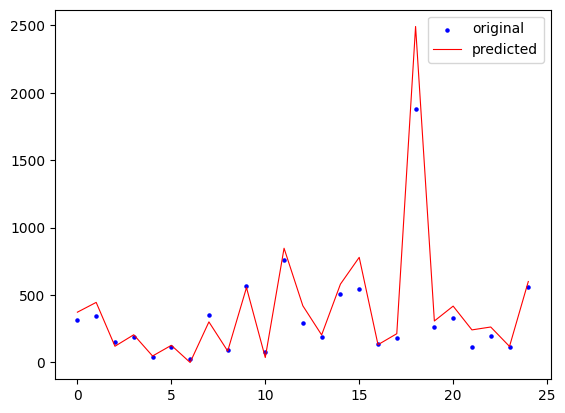

In [60]:
#plotting least angle regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

got much better after turning off normalization, will use in voting

Lasso Lars Regression Model

In [61]:
#building lasso least angle regression model
lassolars = LassoLars(alpha =1)
lassolars.fit(X_train, y_train)

LassoLars(alpha=1)

In [62]:
#testing lasso least angle regression model R2 score on training data
score = lassolars.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.94


In [63]:
#testing lasso least angle regression model mean squared error score
ypred = lassolars.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 24688.64


In [64]:
#testing lasso least angle regression model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.82


In [65]:
#testing lasso least angle regression model root-mean-squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 157.13


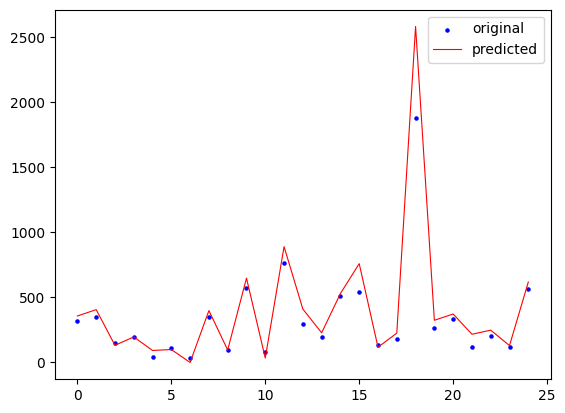

In [66]:
#plotting lasso least angle regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [67]:
#determining best parameters for lasso least angle regression
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'fit_path':[True,False]}

print(grid_search(model = LassoLars(), grid = param_grid_lr))

{'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'normalize': True}


no change from default parameters

In [68]:
#determining best alpha for lasso least angle regression
alphas = [0.1,0.3, 0.5, 0.8, 1]
param_grid_lr = {'alpha':alphas}

print(grid_search(model = LassoLars(), grid = param_grid_lr))

{'alpha': 0.3}


In [69]:
#building tuned lasso least angle regression model
lassolars_tuned = LassoLars(alpha =.3, copy_X = True, fit_intercept = True, fit_path = True, normalize = True )

lassolars_tuned.fit(X_train, y_train)

LassoLars(alpha=0.3)

In [70]:
#testing tuned lasso least angle regression model R2 score on training data
score = lassolars_tuned.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.95


In [71]:
#testing tuned lasso least angle regression model mean squared error score
ypred = lassolars_tuned.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 22310.08


In [72]:
#testing tuned lasso least angle regression model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.83


In [73]:
#testing tuned lasso least angle regression model root-mean-squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 149.37


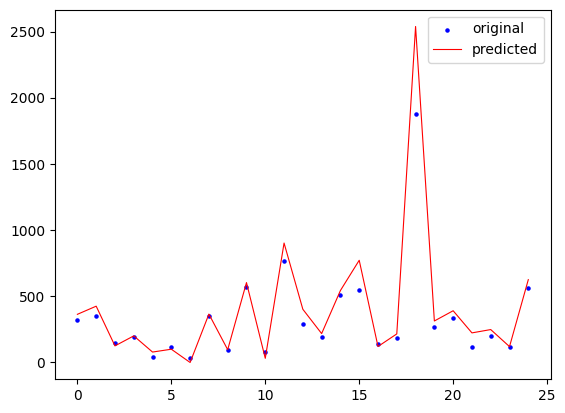

In [74]:
#plotting tuned lasso least angle regression model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

changing alpha had slight impact

Bayseian Ridge Model

In [75]:
#building bayesian ridge model with default parameters
bay_ridge = BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
bay_ridge.fit(X_train, y_train)

BayesianRidge()

In [76]:
#testing bayesian ridge model R2 score on training data
score = bay_ridge.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.94


In [77]:
#testing bayesian ridge model mean squared error
ypred = bay_ridge.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 24075.88


In [78]:
#testing bayesian ridge model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.82


In [79]:
#testing bayesian ridge model 
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 155.16


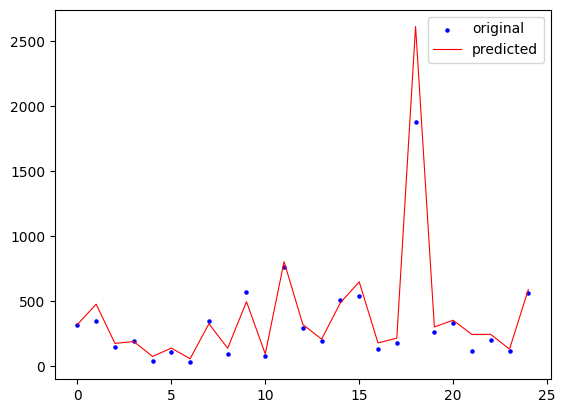

In [80]:
#plotting bayesian ridge model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

In [81]:
#determining best parameters for bayesian ridge regression
param_grid_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

print(grid_search(model = BayesianRidge(), grid = param_grid_lr))

{'copy_X': True, 'fit_intercept': True, 'normalize': False}


In [82]:
#determining best alpha for bayesian ridge regression
alphas = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9]
lambdas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]
param_grid_lr = {'alpha_1':alphas, 'alpha_2':alphas, 'lambda_1':lambdas, 'lambda_2':lambdas}

print(grid_search(model = BayesianRidge(), grid = param_grid_lr))

{'alpha_1': 1, 'alpha_2': 1.9, 'lambda_1': 0.1, 'lambda_2': 1e-09}


In [83]:
#building tuned bayesian ridge model with new parameters
bay_ridge_tuned = BayesianRidge(alpha_1=1, alpha_2=1.9, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=.1, lambda_2=1e-09, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
bay_ridge_tuned.fit(X_train, y_train)

BayesianRidge(alpha_1=1, alpha_2=1.9, lambda_1=0.1, lambda_2=1e-09)

In [84]:
#testing tuned bayesian ridge model R2 score on training data
score = bay_ridge_tuned.score(X_train,y_train)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.94


In [85]:
#testing tuned bayesian ridge model mean squared error
ypred = bay_ridge_tuned.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 24096.82


In [86]:
#testing tuned bayesian ridge model coefficient of determination
cod = r2_score(y_test, ypred)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.82


In [87]:
#testing tuned bayesian ridge model 
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 155.23


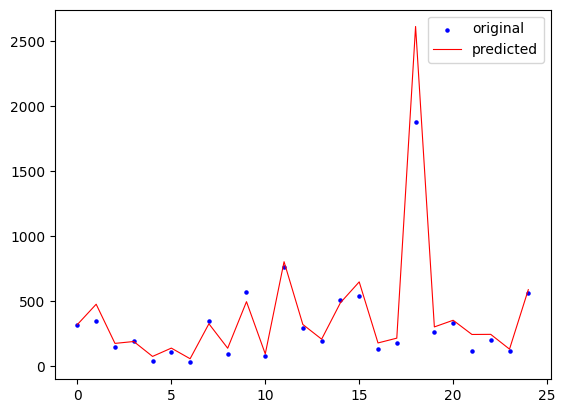

In [88]:
#plotting tuned bayesian ridge model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

tuning actually resulted in a slightly worse model

No weighting 

In [89]:
#Logistic Regression

clf1 = LinearRegression(fit_intercept = False, copy_X = True, normalize = True)

#Lasso Regression

clf2 = Lasso(alpha=1.0, copy_X=True, fit_intercept=True, normalize=True, positive=False) 

#Least Angle Regression

clf3 = Lars(normalize = False)

#Lasso Least Angle Regression

clf4 = LassoLars(alpha = .3)

#Bayesian Ridge

clf5 = BayesianRidge()

#Creating the voting classifier with soft voting because all models performed similarly

clf_voting = VotingRegressor(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3), ('est4', clf4),
                                           ('est5', clf5)])

#fit and predict
clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [90]:
#testing unweighted voting regressor model R2 score
score = r2_score(y_test,pred_voting)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.84


In [91]:
#testing unweighted voting regressor model mean squared error
mse = mean_squared_error(y_test, pred_voting)
print("MSE: %.2f" % mse)

MSE: 21671.59


In [92]:
#testing unweighted voting regressor model coefficient of determination
cod = r2_score(y_test, pred_voting)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.84


In [93]:
#testing unweighted voting regressor model  root mean squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 147.21


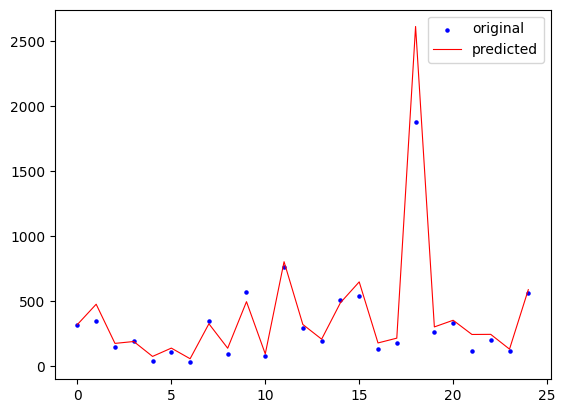

In [94]:
#plotting unweighted voting regressor model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

Ensembling models with weighted voting

In [95]:
# Creating empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
weights4 = []
weights5 = []
scores = []

# Creating a for loop to evaluate different combinations of weights

for i in np.arange(0.05,1, 0.05):
    for j in np.arange(0.05,1, 0.05):
        for k in np.arange(0.05,1, 0.05):
            for l in np.arange(0.05,1, 0.05):
                for m in np.arange(0.05,1, 0.05):
                    clf_voting = VotingRegressor(estimators = [('est1', clf1), ('est2', clf2), ('est3', clf3),
                                            ('est4', clf4), ('est5', clf5)], weights = [i, j, k, l, m])
                    clf_voting.fit(X_train, y_train)
                    pred = clf_voting.predict(X_test)
                    score = r2_score(y_test,pred)
                    scores.append(score)
                    weights1.append(i)
                    weights2.append(j)
                    weights3.append(k)
                    weights4.append(l)
                    weights5.append(m)

In [96]:
# Saving the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Weight4'] = weights4
test_scores['Weight5'] = weights5
test_scores['Test Score'] = scores

# Creating an additional column to save the sum of all the weights

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2']).add(test_scores['Weight3']).add(test_scores['Weight4']).add(test_scores['Weight5'])

#We are only getting the rows that the sum of all weights were equal to one

condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

In [97]:
# Sorting the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test Score', ascending = False).head(15)

,Weight1,Weight2,Weight3,Weight4,Weight5,Test Score,sum_weights
5415,0.05,0.05,0.80,0.05,0.05,0.845977,1.0
655215,0.30,0.05,0.55,0.05,0.05,0.845826,1.0
785175,0.35,0.05,0.50,0.05,0.05,0.845781,1.0
915135,0.40,0.05,0.45,0.05,0.05,0.845731,1.0
1045095,0.45,0.05,0.40,0.05,0.05,0.845677,1.0
654855,0.30,0.05,0.50,0.05,0.10,0.845490,1.0
5073,0.05,0.05,0.75,0.10,0.05,0.845487,1.0
135033,0.10,0.05,0.70,0.10,0.05,0.845475,1.0
264993,0.15,0.05,0.65,0.10,0.05,0.845458,1.0
394953,0.20,0.05,0.60,0.10,0.05,0.845435,1.0


In [116]:
# Creating the Voting Classifier with the most equally weighted because all models performed similarly

clf_voting = VotingRegressor(estimators = [('est1', clf1), ('est2', clf2), ('est3', clf3)
                                           , ('est4', clf4),  ('est5', clf5)], weights = [0.05, 0.05, 0.80, .05, .05])

#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

In [117]:
#testing weighted voting regressor model R2 score
score = r2_score(y_test,pred_voting)
print("Model score (R-squared): %.2f" % score)

Model score (R-squared): 0.85


In [118]:
#testing weighted voting regressor model mean squared error
mse = mean_squared_error(y_test, pred_voting)
print("MSE: %.2f" % mse)

MSE: 20730.20


In [119]:
#testing weighted voting regressor model coefficient of determination
cod = r2_score(y_test, pred_voting)
print("Coefficient of determination: %.2f" % cod)

Coefficient of determination: 0.85


In [120]:
#testing weighted voting regressor model  root mean squared error
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 143.98


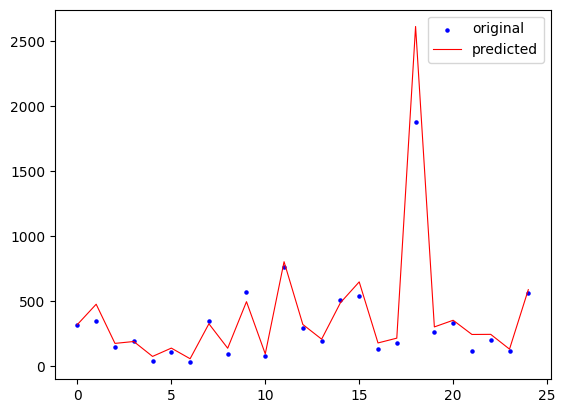

In [110]:
#plotting weighted voting regressor model
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

Turns out the third model that was built (Least angle regression) was superior than any other model. So much so that when ensembled, the other models ended up pulling down the final model. Our Lars model had a coefficiant of determination of .85 which was equal to the ensemble model's .85. The Lars model had a RMSE of 143.19 which was slightly better than the ensemble model's RMSE of 143.98. The Lars model had a MSE of 20504.16 which was slightly better than the ensemble model's MSE of 20730.20. Interestingly this was the worst model before tuning. 